# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [97]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

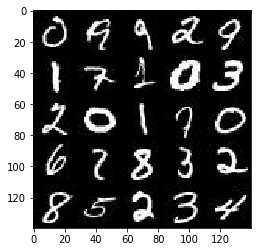

In [98]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

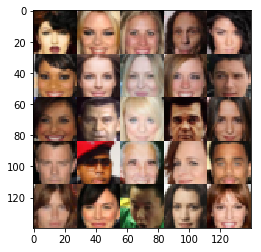

In [99]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [100]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [101]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real') 
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z') 
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [102]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 56, 5, strides=2, padding='same', 
                              kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x56
    
        x2 = tf.layers.conv2d(relu1, 112, 5, strides=2, padding='same', 
                              kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x112

        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*112))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [103]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*112)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 112))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x112 now
        
        x2 = tf.layers.conv2d_transpose(x1, 56, 5, strides=2, padding='same',
                                        kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x224 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same', 
                                            kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [104]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    alpha = 0.2
    g_model = generator(input_z, out_channel_dim, is_train = True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [105]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [106]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [113]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Set model inputs
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    # Set model loss
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    # Set model optimization
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    samples, losses = [], []
    steps    = 0
    
    saver    = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images * 2
                
                # Sample random noise for G
                sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: sample_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: sample_z, learn_rate: learning_rate, input_real: batch_images}) 
            
                                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: sample_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: sample_z})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 30, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8863... Generator Loss: 0.6418
Epoch 1/2... Discriminator Loss: 0.7253... Generator Loss: 0.8939
Epoch 1/2... Discriminator Loss: 0.9547... Generator Loss: 0.5846
Epoch 1/2... Discriminator Loss: 0.4710... Generator Loss: 2.0361
Epoch 1/2... Discriminator Loss: 0.4062... Generator Loss: 1.3503
Epoch 1/2... Discriminator Loss: 0.5742... Generator Loss: 1.4252
Epoch 1/2... Discriminator Loss: 0.5170... Generator Loss: 1.4029
Epoch 1/2... Discriminator Loss: 0.6331... Generator Loss: 1.6940
Epoch 1/2... Discriminator Loss: 2.1430... Generator Loss: 0.1389
Epoch 1/2... Discriminator Loss: 0.9052... Generator Loss: 2.2156


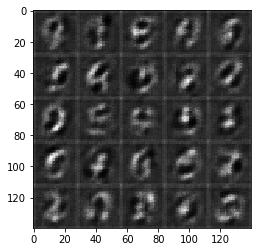

Epoch 1/2... Discriminator Loss: 1.5140... Generator Loss: 0.2972
Epoch 1/2... Discriminator Loss: 0.9967... Generator Loss: 1.9652
Epoch 1/2... Discriminator Loss: 1.5096... Generator Loss: 0.2978
Epoch 1/2... Discriminator Loss: 0.9723... Generator Loss: 1.8162
Epoch 1/2... Discriminator Loss: 0.8969... Generator Loss: 0.9499
Epoch 1/2... Discriminator Loss: 0.8136... Generator Loss: 1.0877
Epoch 1/2... Discriminator Loss: 0.9040... Generator Loss: 1.2764
Epoch 1/2... Discriminator Loss: 0.8213... Generator Loss: 1.1986
Epoch 1/2... Discriminator Loss: 0.9105... Generator Loss: 1.1357
Epoch 1/2... Discriminator Loss: 0.9808... Generator Loss: 1.6841


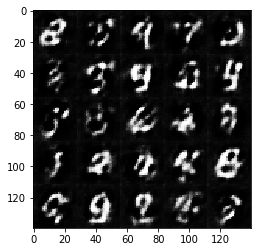

Epoch 1/2... Discriminator Loss: 1.2755... Generator Loss: 1.9275
Epoch 1/2... Discriminator Loss: 1.0972... Generator Loss: 0.5920
Epoch 1/2... Discriminator Loss: 1.0114... Generator Loss: 0.6995
Epoch 1/2... Discriminator Loss: 1.3041... Generator Loss: 0.4207
Epoch 1/2... Discriminator Loss: 1.1643... Generator Loss: 0.5179
Epoch 1/2... Discriminator Loss: 0.9932... Generator Loss: 1.0043
Epoch 1/2... Discriminator Loss: 1.3703... Generator Loss: 1.8264
Epoch 1/2... Discriminator Loss: 1.0873... Generator Loss: 1.0073
Epoch 1/2... Discriminator Loss: 1.0993... Generator Loss: 1.2925
Epoch 1/2... Discriminator Loss: 1.2806... Generator Loss: 1.6190


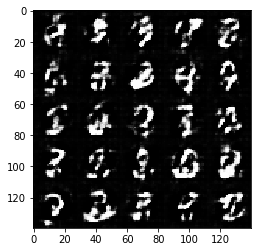

Epoch 1/2... Discriminator Loss: 0.9970... Generator Loss: 1.1579
Epoch 1/2... Discriminator Loss: 0.9935... Generator Loss: 0.8516
Epoch 1/2... Discriminator Loss: 1.0239... Generator Loss: 0.8732
Epoch 1/2... Discriminator Loss: 0.9838... Generator Loss: 0.7245
Epoch 1/2... Discriminator Loss: 1.0440... Generator Loss: 1.9385
Epoch 1/2... Discriminator Loss: 0.8782... Generator Loss: 1.3249
Epoch 1/2... Discriminator Loss: 0.9447... Generator Loss: 0.8293
Epoch 1/2... Discriminator Loss: 0.8960... Generator Loss: 0.9185
Epoch 1/2... Discriminator Loss: 0.8431... Generator Loss: 1.2450
Epoch 1/2... Discriminator Loss: 0.8723... Generator Loss: 1.0208


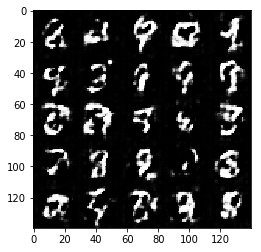

Epoch 1/2... Discriminator Loss: 0.8077... Generator Loss: 1.0908
Epoch 1/2... Discriminator Loss: 0.7395... Generator Loss: 1.1483
Epoch 1/2... Discriminator Loss: 0.7405... Generator Loss: 1.1911
Epoch 1/2... Discriminator Loss: 0.8348... Generator Loss: 1.6602
Epoch 1/2... Discriminator Loss: 0.8340... Generator Loss: 0.9841
Epoch 1/2... Discriminator Loss: 0.7985... Generator Loss: 0.9592
Epoch 2/2... Discriminator Loss: 0.9023... Generator Loss: 1.9806
Epoch 2/2... Discriminator Loss: 0.7508... Generator Loss: 1.6538
Epoch 2/2... Discriminator Loss: 0.8119... Generator Loss: 1.2116
Epoch 2/2... Discriminator Loss: 0.7061... Generator Loss: 1.3830


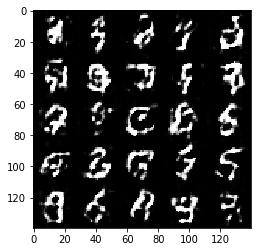

Epoch 2/2... Discriminator Loss: 0.9736... Generator Loss: 0.5928
Epoch 2/2... Discriminator Loss: 0.8656... Generator Loss: 1.5884
Epoch 2/2... Discriminator Loss: 0.7838... Generator Loss: 0.9795
Epoch 2/2... Discriminator Loss: 0.7955... Generator Loss: 1.2376
Epoch 2/2... Discriminator Loss: 0.8254... Generator Loss: 0.9859
Epoch 2/2... Discriminator Loss: 0.9131... Generator Loss: 0.7055
Epoch 2/2... Discriminator Loss: 0.7617... Generator Loss: 1.6144
Epoch 2/2... Discriminator Loss: 0.6961... Generator Loss: 1.1896
Epoch 2/2... Discriminator Loss: 0.9383... Generator Loss: 2.2245
Epoch 2/2... Discriminator Loss: 0.7034... Generator Loss: 1.7700


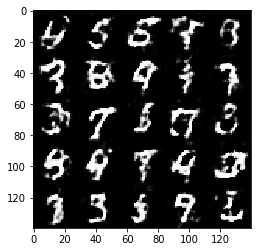

Epoch 2/2... Discriminator Loss: 0.7162... Generator Loss: 1.4532
Epoch 2/2... Discriminator Loss: 0.8013... Generator Loss: 1.1270
Epoch 2/2... Discriminator Loss: 0.8152... Generator Loss: 1.3023
Epoch 2/2... Discriminator Loss: 0.8202... Generator Loss: 1.5691
Epoch 2/2... Discriminator Loss: 0.9247... Generator Loss: 1.1067
Epoch 2/2... Discriminator Loss: 0.9342... Generator Loss: 1.4880
Epoch 2/2... Discriminator Loss: 0.8471... Generator Loss: 1.5040
Epoch 2/2... Discriminator Loss: 0.7365... Generator Loss: 1.1958
Epoch 2/2... Discriminator Loss: 0.8488... Generator Loss: 1.6107
Epoch 2/2... Discriminator Loss: 0.8385... Generator Loss: 1.4650


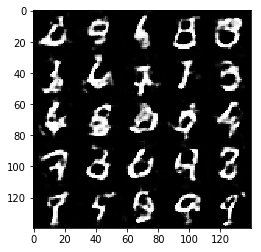

Epoch 2/2... Discriminator Loss: 0.9262... Generator Loss: 1.4339
Epoch 2/2... Discriminator Loss: 0.8247... Generator Loss: 1.2803
Epoch 2/2... Discriminator Loss: 0.8625... Generator Loss: 1.7321
Epoch 2/2... Discriminator Loss: 0.8333... Generator Loss: 1.0715
Epoch 2/2... Discriminator Loss: 0.9806... Generator Loss: 1.2499
Epoch 2/2... Discriminator Loss: 1.0261... Generator Loss: 1.5159
Epoch 2/2... Discriminator Loss: 0.9446... Generator Loss: 0.8324
Epoch 2/2... Discriminator Loss: 0.9608... Generator Loss: 1.5222
Epoch 2/2... Discriminator Loss: 0.9043... Generator Loss: 1.1996
Epoch 2/2... Discriminator Loss: 0.9343... Generator Loss: 1.4270


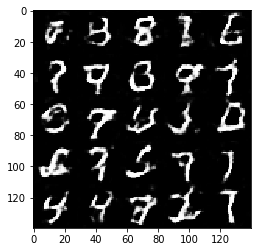

Epoch 2/2... Discriminator Loss: 0.9765... Generator Loss: 0.7060
Epoch 2/2... Discriminator Loss: 0.9699... Generator Loss: 0.7444
Epoch 2/2... Discriminator Loss: 0.9274... Generator Loss: 0.9455
Epoch 2/2... Discriminator Loss: 0.9738... Generator Loss: 1.0350
Epoch 2/2... Discriminator Loss: 0.9082... Generator Loss: 0.7914
Epoch 2/2... Discriminator Loss: 0.8962... Generator Loss: 1.5168
Epoch 2/2... Discriminator Loss: 1.0023... Generator Loss: 1.2312
Epoch 2/2... Discriminator Loss: 0.9315... Generator Loss: 0.8010
Epoch 2/2... Discriminator Loss: 1.0902... Generator Loss: 0.5815
Epoch 2/2... Discriminator Loss: 0.9445... Generator Loss: 1.4743


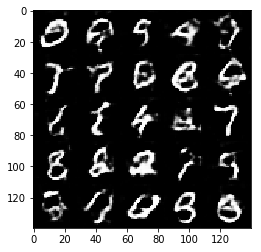

Epoch 2/2... Discriminator Loss: 0.8999... Generator Loss: 1.4566
Epoch 2/2... Discriminator Loss: 0.9212... Generator Loss: 0.9445
Epoch 2/2... Discriminator Loss: 1.0071... Generator Loss: 1.6827


In [114]:
batch_size = 128
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8445... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 0.7202... Generator Loss: 0.9804
Epoch 1/1... Discriminator Loss: 0.5250... Generator Loss: 1.3528
Epoch 1/1... Discriminator Loss: 0.4058... Generator Loss: 1.5027
Epoch 1/1... Discriminator Loss: 0.4632... Generator Loss: 1.7009
Epoch 1/1... Discriminator Loss: 0.5724... Generator Loss: 1.1913
Epoch 1/1... Discriminator Loss: 0.8688... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 0.9575... Generator Loss: 1.8490
Epoch 1/1... Discriminator Loss: 0.8769... Generator Loss: 1.2050
Epoch 1/1... Discriminator Loss: 0.8446... Generator Loss: 1.2862


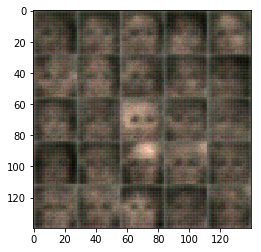

Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 1.3604
Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 0.9891... Generator Loss: 1.0044
Epoch 1/1... Discriminator Loss: 0.9555... Generator Loss: 1.0050
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 1.0089
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 1.5805
Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 0.9464
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.6996


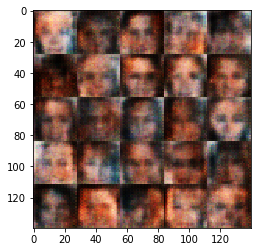

Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 0.9472
Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 1.0537
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.4574
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.1158... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 0.9159
Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 1.0567
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 0.8931
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.9436


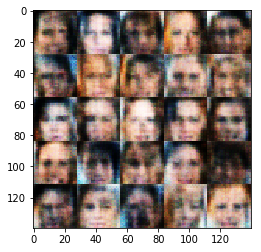

Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 1.1360
Epoch 1/1... Discriminator Loss: 1.5381... Generator Loss: 0.4374
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 0.9355
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 1.1704
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.9574
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.4736
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.9530
Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 1.3539
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.6258


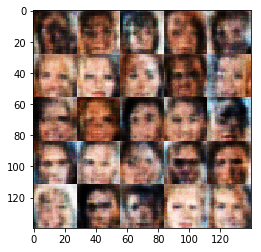

Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.8474
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.9003
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 1.2562
Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 1.0624
Epoch 1/1... Discriminator Loss: 1.1133... Generator Loss: 0.8939


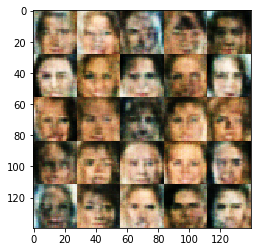

Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.9355
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 1.1749
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.8508
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 0.9679
Epoch 1/1... Discriminator Loss: 1.0815... Generator Loss: 1.1754
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.9428


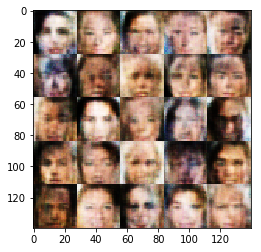

Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.5623
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.9039
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 0.9263
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 1.2019


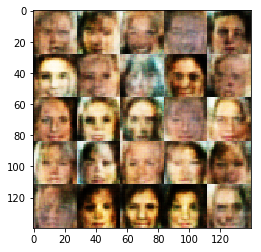

Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.8565
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 0.9477
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 0.7191


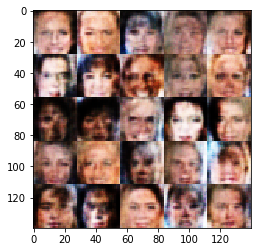

Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.9095
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.8501
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 1.0311
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.7396


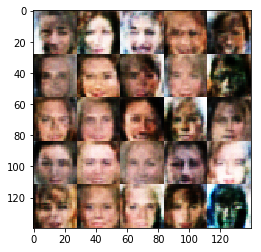

Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.6349
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.9302
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.7894


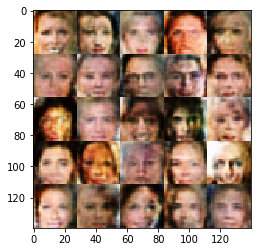

Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 1.0402
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.5922
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.5713
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.6017


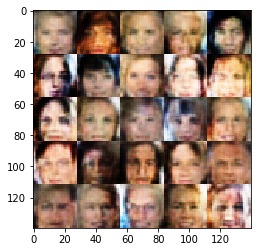

Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 0.9403
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.8491
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.6106
Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 0.7885


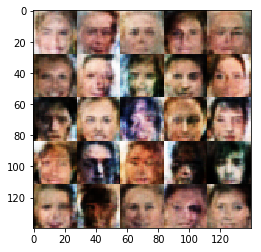

Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 0.9133
Epoch 1/1... Discriminator Loss: 1.0953... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 1.2752
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.8897
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 0.7490


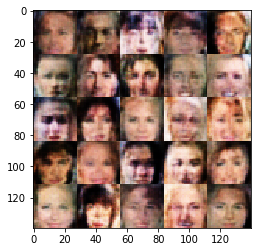

Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.9075
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.0679... Generator Loss: 0.9027
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.9727
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 0.9301
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.7729


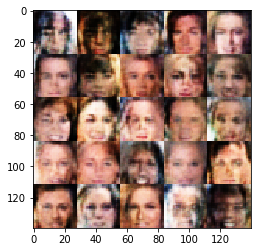

Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 1.1016
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 1.0866
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 0.6816


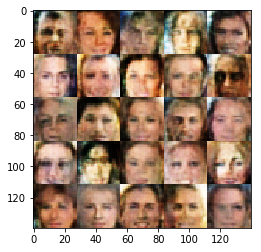

Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 1.0662
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 1.0300
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 0.9156
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 1.0097
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 0.7624


In [115]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.